# Tutorial: Using `fastai.data` low-level APIs

> Using `DataSource`, `Pipeline`, `TfmdList`, `TfmOver`, and `Transform`

In [ ]:
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

from PIL.ImageFile import ImageFile

## setup

In [ ]:
def mk_tensor(im): return tensor(array(im))[None]

@patch
def dihedral(im:ImageFile, idx=0): return im.transpose(idx-1) if idx>=1 else im
def rand_dihedral(im): return im.dihedral(random.randint(0,7))

def normalize  (o,m,s): return (o-m)/s
def denormalize(o,m,s): return (o*s)+m

def decode_vocab(o, v): return [v[o_] for o_ in o]

In [ ]:
source = untar_data(URLs.MNIST_TINY)/'train'
items = get_image_files(source)
fn = items[0]
img = PIL.Image.open(fn)
m,s = 0.1,0.3

In [ ]:
imgt = mk_tensor(img)

lbls = items.mapped(parent_label)
itos,stoi = uniqueify(lbls, bidir=True, sort=True)

## v5

In [ ]:
vocab = SimpleNamespace(itos=itos,stoi=stoi)

In [ ]:
def _get_types(func):
    sig = inspect.signature(func)
    t_out = sig.return_annotation if sig.return_annotation != inspect._empty else None
    t_in = [p.annotation if p.annotation != inspect._empty else None 
            for p in sig.parameters.values() if p.default == inspect._empty and p.kind != inspect._VAR_KEYWORD]
#     if not t_out: t_out = t_in[0]
    return (len(t_in) > 1,t_out)

def _check_same(t1, t2):
    assert t1 is None or t2 is None or t1 == t2
    return t2 if t1 is None else t1

In [ ]:
class Transform(metaclass=PrePostInitMeta):
    def __init__(self, encodes=None):
        if encodes is not None: self.encodes = encodes
    
    def __post_init__(self):
        is_tuple_in, t1 = _get_types(self.encodes) if hasattr(self, 'encodes') else (False,None)
        is_tuple_out,t2 = _get_types(self.decodes) if hasattr(self, 'decodes') else (False,None)
        assert is_tuple_in == is_tuple_out
        self.type = _check_same(t1, t2)
        self.is_tuple = is_tuple_in
        
    def __getattr__(self,k):
        if k not in ['encodes', 'decodes', 'decode']:
            def _inner(x, *args, **kwargs):
                return getattr(self.type,  k, noop)(x, *args, **kwargs)
            return _inner
        else: raise AttributeError
    
    def _apply(self, n, o):
        if is_listy(self.type) and not self.is_tuple:
            old_type = self.type
            res = []
            for o_,t in zip(o,old_type):
                self.type=t
                res.append(getattr(self, n, noop)(o_))
            self.type = old_type
            return tuple(res)
        return getattr(self, n, noop)(*L(o))
    
    def __call__(self, o): return self._apply('encodes', o)            
    def decode(self, o):   return self._apply('decodes', o)

In [ ]:
class String():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_title(str(o), ctx=ctx)

In [ ]:
String.show("3")

3


In [ ]:
class Categorify(Transform):
    def __init__(self, vocab): self.vocab = vocab
    def encodes(self, s): return self.vocab.stoi[getattr(s, 'data', s)]
    def decodes(self, i) -> String: return self.vocab.itos[i]

In [ ]:
tst = Categorify(vocab)
tst.type

__main__.String

In [ ]:
class TensorImage():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_image(to_cpu(o), ctx=ctx, **kwargs)

In [ ]:
def mk_tensor(im) -> TensorImage: return tensor(array(im))[None]

In [ ]:
def compose_tfms(x, tfms, func_nm='__call__', reverse=False):
    if reverse: tfms = reversed(tfms)
    for tfm in tfms: x = getattr(tfm,func_nm,noop)(x)
    return x

In [ ]:
class Pipeline():
    def __init__(self, *tfms): 
        self.tfms = [t if isinstance(t, Transform) else Transform(t) for t in tfms]
        
    def setup(self, t=None):
        if len(self.tfms) == 0: self.final_t = t
        else:
            if self.tfms[0].type is None: self.tfms[0].type = t
            for t_prec,t in zip(self.tfms[:-1],self.tfms[1:]):
                if t.type is None: t.type = t_prec.type
            self.final_t = self.tfms[-1].type
                
    def __call__(self, o): return compose_tfms(o, self.tfms)
    def decode  (self, i): return compose_tfms(i, self.tfms, func_nm='decode', reverse=True)
    def show(self, o, ctx=None, **kwargs):
        r_tfms = list(reversed(self.tfms))
        for i,tfm in enumerate(r_tfms):
            o = tfm.decode(o)
            if hasattr(tfm.type, 'show') and (i==len(r_tfms)-1 or r_tfms[i+1].type!=tfm.type):
                #tfm.type knows how to show AND is the first tfm with this type
                return tfm.type.show(o, ctx=ctx, **kwargs)

In [ ]:
class MNIST():
    def __init__(self, items, pipes, tuple_pipe):
        self.items,self.pipes,self.tuple_pipe = items,pipes,tuple_pipe
        for p in self.pipes: p.setup()
        self.tuple_pipe.setup(t = [p.final_t for p in self.pipes])
        
    def __getitem__(self, i): return self.tuple_pipe([p(self.items[i]) for p in self.pipes])
    def __len__(self): return len(items)
    
    def show(self, o, ctx=None, **kwargs):
        o = self.tuple_pipe.decode(o)
        for o_,p in zip(o,self.pipes): ctx = p.show(o_, ctx=ctx, **kwargs)
        return ctx
        
    def show_at(self, i, ctx=None, **kwargs): return self.show(self[i], ctx=ctx, **kwargs)

In [ ]:
pipe_x = Pipeline(PIL.Image.open, rand_dihedral, mk_tensor)
pipe_y = Pipeline(parent_label, Categorify(vocab))

In [ ]:
ds = MNIST(items, [pipe_x, pipe_y], Pipeline())

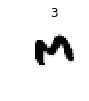

In [ ]:
ds.show_at(0, cmap="Greys", figsize=(1,1))

In [ ]:
ds.tuple_pipe.final_t

[__main__.TensorImage, __main__.String]

In [ ]:
dl = DataLoader(ds, batch_size=9)

In [ ]:
@patch
def floatify(x:TensorImage): return x.float()/255.

In [ ]:
class Normalize(Transform):
    def __init__(self, m, s): self.m,self.s = m,s
    def encodes(self, o)->TensorImage: return (o-self.m)/self.s
    def decodes(self, o):              return (o*self.s)+self.m

norm_mnist = Normalize(m,s)

In [ ]:
imgf = floatify(imgt)

In [ ]:
imgf.mean(),imgf.std()

(tensor(0.1983), tensor(0.3761))

In [ ]:
imgn = norm_mnist(imgf)
imgn.mean(),imgn.std()

(tensor(0.3277), tensor(1.2535))

In [ ]:
imgf2 = norm_mnist.decode(imgn)
imgf2.mean(),imgf2.std()

(tensor(0.1983), tensor(0.3761))

In [ ]:
norm_mnist = Normalize(m,s)
dl_pipe = Pipeline(to_device, floatify, norm_mnist)

In [ ]:
class MNIST_DL():
    def __init__(self, dl, f): 
        self.dl,self.f = dl,f
        t = getattr(self.dl.dataset.tuple_pipe, 'final_t', None) if hasattr(self.dl.dataset, 'tuple_pipe') else None
        self.f.setup(t=t)
        
    def __iter__(self): return (self.f(b) for b in self.dl)
    def __len__(self): return len(self.dl)
    
    def show_batch(self, b, max_rows=10, ctxs=None, **kwargs):
        b = self.f.decode(b) 
        rows = itertools.islice(zip(*L(b)), max_rows)
        if ctxs is None: ctxs = [None] * len(b[0] if is_iter(b[0]) else b)
        for o,ctx in zip(rows,ctxs): self.dl.dataset.show(o, ctx=ctx, **kwargs)

In [ ]:
mdl = MNIST_DL(dl, dl_pipe)

In [ ]:
b = next(iter(mdl))

b[0].shape,b[1].shape, b[0].mean(), b[0].std()
assert b[0].min()<0

TypeError: encodes() takes 2 positional arguments but 3 were given

In [ ]:
mdl.f.final_t

In [ ]:
fig,axs = plt.subplots(3,3)
mdl.show_batch(b, cmap="Greys", figsize=(4,4), ctxs=axs.flat)

## v6

In [ ]:
class Transform(PrePostInit):
    def __init__(self,encode=None,decode=None):
        if encode: self.encode = encode
        if decode: self.decode = decode

In [ ]:
@patch
def powx(x:math, a): return math.pow(x,a)

@patch
def powx(x:torch, a): return torch.pow(x,a)

class Add1(Transform):
    def encode(self,x): return x+1
    def decode(self,x): return x-1

def mk_torch(x)->torch: return tensor(x)
def mk_int  (x)->math : return x

In [ ]:
class Func():
    def __init__(self, nm, *args, **kwargs): self.nm,self.args,self.kwargs = nm,args,kwargs
    def __repr__(self): return f'sig: {self.nm}({self.args}, {self.kwargs})'
    def __call__(self,t):
        f = getattr(t,self.nm)
        if not (self.args or self.kwargs): return f
        return partial(f, *self.args, **self.kwargs)
    
class SelfFunc():
    def __init__(self, nm, *args, **kwargs): self.nm,self.args,self.kwargs = nm,args,kwargs
    def __repr__(self): return f'self: {self.nm}({self.args}, {self.kwargs})'
    def __call__(self, o):
        return getattr(o,self.nm)(*self.args, **self.kwargs)
    
class _Sig():
    def __getattr__(self,k):
        def _inner(*args, **kwargs):
            return Func(k, *args, **kwargs)
        return _inner

class _SelfFunc():
    def __getattr__(self,k):
        def _inner(*args, **kwargs):
            return SelfFunc(k, *args, **kwargs)
        return _inner

Sig = _Sig()
Self = _SelfFunc()

In [ ]:
pipe_funcs = [Add1(), (Sig.powx(a=2), 'sqrt'), mk_torch, (Self.reciprocal(),Self.reciprocal())]

pf1 = [mk_int  ] + pipe_funcs
pf2 = [mk_torch] + pipe_funcs

In [ ]:
def mk_func(f, t):
    if isinstance(f,str ): f = Func(f)
    if isinstance(f,Func): f = f(t)
    return f

def mk_tfm(f,t):
    if not is_listy(f): f = (f,None)
    return Transform(mk_func(f[0],t), mk_func(f[1],t))

In [ ]:
def compose_tfms(x, tfms, func_nm='encode', reverse=False):
    if reverse: tfms = reversed(tfms)
    for tfm in tfms: x = getattr(tfm,func_nm,noop)(x)
    return x

In [ ]:
def _get_ret(func):
    ann = getattr(func,'__annotations__', None)
    if not ann: return None
    return ann.get('return')

In [ ]:
class Pipeline():
    def __init__(self, funcs):
        self.fs = []
        self.t = None
        for f in funcs:
            if not isinstance(f,Transform): f = mk_tfm(f, self.t)
            self.fs.append(f)
            self.t = _get_ret(f.encode) or self.t
                
    def __call__(self, o): return compose_tfms(o, self.fs)
    def decode  (self, i): return compose_tfms(i, self.fs, func_nm='decode', reverse=True)

In [ ]:
p1 = Pipeline(pf1)
a1 = p1(1.5); a1

tensor(0.1600)

In [ ]:
p1.decode(a1)

1.5

In [ ]:
p2 = Pipeline(pf2)
a2 = p2(tensor(1.5)); a2

tensor(0.1600)

In [ ]:
p2.decode(a2)

tensor(1.5000)

## fin